In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [0]:
import preprocess

In [0]:
num_examples=50000

input_tensor, target_tensor, inp_lang, targ_lang = preprocess.load_dataset(path_to_file,num_examples)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [5]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

40000 40000 10000 10000


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [7]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6935 ----> raramente
108 ----> va
8 ----> el
10 ----> a
13 ----> la
1188 ----> iglesia
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
15 ----> he
1072 ----> seldom
617 ----> goes
10 ----> to
1061 ----> church
3 ----> .
2 ----> <end>


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [9]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 12]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,enc_units,batch_sz):
    super(Encoder,self).__init__()
    self.enc_units = enc_units
    self.batch_sz = batch_sz
    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
  def call(self,inp,hidden):
      x = self.embedding(inp)
      output,state = self.gru(x,initial_state=hidden)
      return output,state

  def initialize_hidden_state(self):
    return tf.zeros([self.batch_sz,self.enc_units]) 



In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [12]:
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(BahdanauAttention,self).__init__()
    self.units = units
    self.W1 = tf.keras.layers.Dense(self.units)
    self.W2 = tf.keras.layers.Dense(self.units)
    self.V = tf.keras.layers.Dense(1)

  def call(self,query,values):

    query_with_time_axis = tf.expand_dims(query,1)

    score = self.V(tf.keras.activations.tanh(
                                        self.W1(query_with_time_axis)+
                                        self.W2(values)
                                  ))
    attention_weights = tf.keras.activations.softmax(score,1)

    context_vector =  attention_weights*values
    context_vector = tf.reduce_sum(context_vector,1)

    return context_vector,attention_weights

In [14]:
attention_layer = BahdanauAttention(10)
attention_result,attention_weights = attention_layer(sample_hidden,sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,dec_units,batch_sz):
    super(Decoder,self).__init__()
    self.dec_units = dec_units
    self.batch_sz = batch_sz
    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
    self.gru =              tf.keras.layers.GRU(dec_units,
                                               return_sequences=True,
                                               return_state=True,
                                               recurrent_initializer='glorot_uniform')
    
    self.fc = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.dec_units)

  def call(self,x,hidden,enc_output):
    context_vector,attention_weights = self.attention(hidden,enc_output)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector,1),x],axis=-1)

    output,state = self.gru(x)
    output = tf.reshape(output,(-1,output.shape[2]))
    
    x = self.fc(output)
    return x,state,attention_weights


In [16]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output,_,_ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6817)


In [0]:
optimizer= tf.keras.optimizers.Adam()
loss_object= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

def loss_function(real,pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss_object(real,pred)

  mask = tf.cast(mask,dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
def train_step(inp,targ,enc_hidden):
  loss=0
  with tf.GradientTape() as tape:
    enc_output,enc_hidden = encoder(inp,enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']]*BATCH_SIZE,1)

    for t in range(1,targ.shape[1]):
      predictions,dec_hidden,_ = decoder(dec_input,dec_hidden,enc_output)
      loss += loss_function(targ[:,t],predictions)
      dec_input = tf.expand_dims(targ[:,t],1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss


In [20]:
EPOCH=10
for epoch in range(EPOCH):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch,(inp,targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 9 Batch 300 Loss 0.0945
Epoch 9 Batch 400 Loss 0.0900
Epoch 9 Batch 500 Loss 0.1081
Epoch 9 Batch 600 Loss 0.1324
Epoch 9 Loss 0.0997
Time taken for 1 epoch 131.86188864707947 sec

Epoch 10 Batch 0 Loss 0.0988
Epoch 10 Batch 100 Loss 0.0701
Epoch 10 Batch 200 Loss 0.1021
Epoch 10 Batch 300 Loss 0.1326
Epoch 10 Batch 400 Loss 0.0911
Epoch 10 Batch 500 Loss 0.0863
Epoch 10 Batch 600 Loss 0.1057
Epoch 10 Loss 0.0864
Time taken for 1 epoch 132.73140954971313 sec



In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess.preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [54]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s too cold here . <end> 


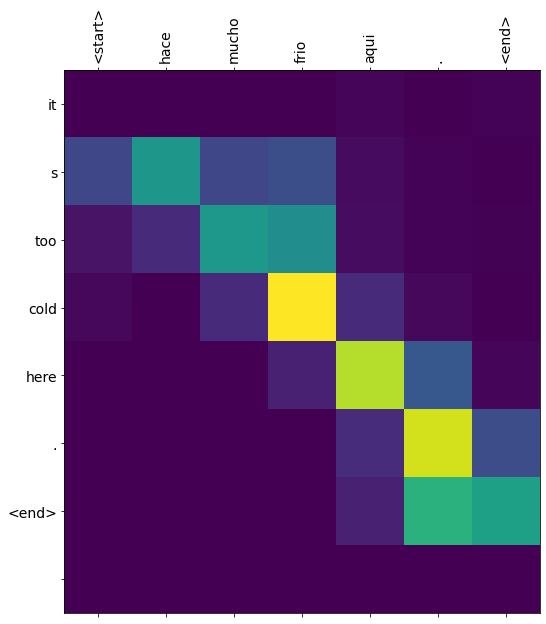

In [55]:
translate(u'hace mucho frio aqui.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


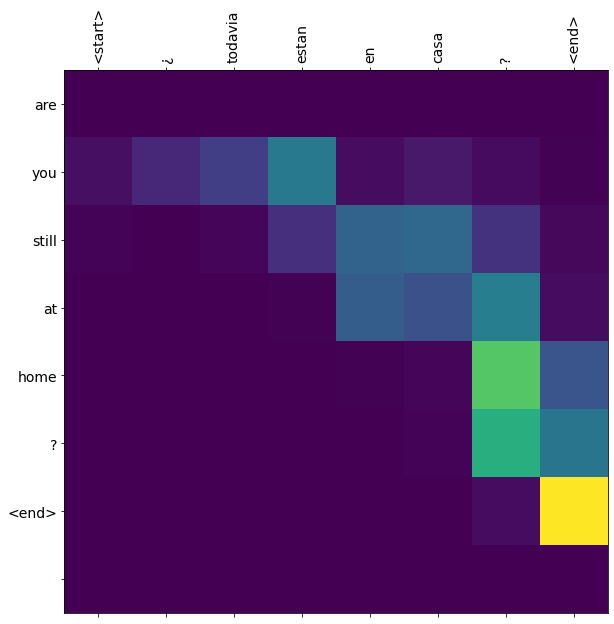

In [56]:
translate(u'¿todavia estan en casa?')